In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV

from astroML.utils import completeness_contamination
from astroML.classification import GMMBayes
from astroML.utils import pickle_results

import corner

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "cm",
      "font.size" : "12",
      "figure.figsize" : [8,8]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

In [2]:
file = '../solutions/galaxyquasar.csv'
data= np.genfromtxt(file, delimiter=',', dtype = str)
print(data)

[['u' 'g' 'r' ... 'class' 'z1' 'zerr']
 ['18.97213' '18.53676' '18.5828' ... 'QSO' '0.5228189' '0.0001547483']
 ['19.24592' '17.47646' '16.47817' ... 'GALAXY' '0.1228459'
  '2.816076E-05']
 ...
 ['18.62718' '17.30876' '16.87371' ... 'GALAXY' '0.05442934'
  '8.433598E-06']
 ['19.5514' '18.27711' '17.62101' ... 'GALAXY' '0.1125709' '9.286238E-06']
 ['18.80772' '17.75751' '17.405' ... 'GALAXY' '0.04365238' '7.415751E-06']]


In [3]:
#colors
ug = data[1:,0].astype(float) - data[1:,1].astype(float)
gr = data[1:,1].astype(float) - data[1:,2].astype(float)
ri = data[1:,2].astype(float) - data[1:,3].astype(float)
iz = data[1:,3].astype(float) - data[1:,4].astype(float)

galaxies = data[1:,0:4][data[1:,5]=='GALAXY'].astype(float)
quasars = data[1:,0:4][data[1:,5]=='QSO'].astype(float)

labels = np.char.replace(data[1:,5], 'GALAXY', '0')
labels = np.char.replace(labels, 'QSO', '1').astype(float)

In [4]:
ug_train, ug_test, gr_train, gr_test, ri_train, ri_test, iz_train, iz_test, labels_train, labels_test = train_test_split(ug, gr, ri, iz, labels, test_size=0.3)


In [5]:
colors_train = np.column_stack((ug_train, gr_train, ri_train, iz_train))
colors_test = np.column_stack((ug_test, gr_test, ri_test, iz_test))
labels_corner = [r'$u-g$', r'$g-r$', r'$r-i$', r'$i-z$']

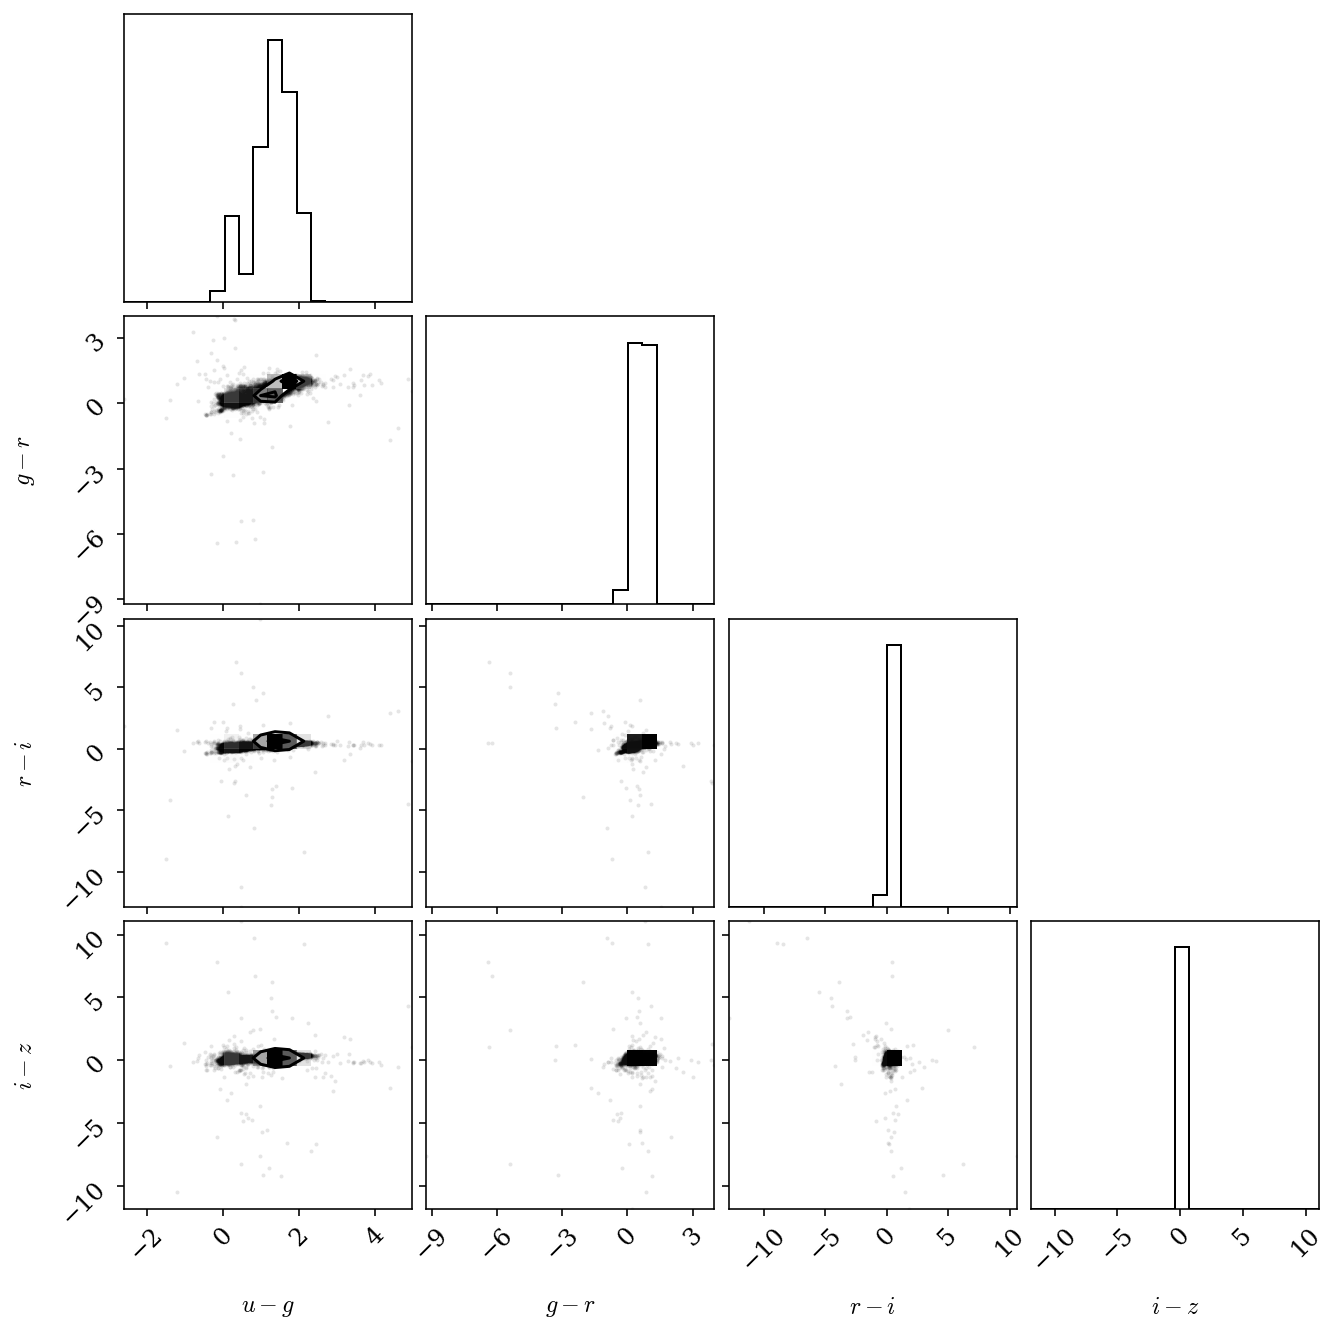

In [6]:
corner.corner(colors_train, labels = labels_corner);

$u-g$ is the most promising color 

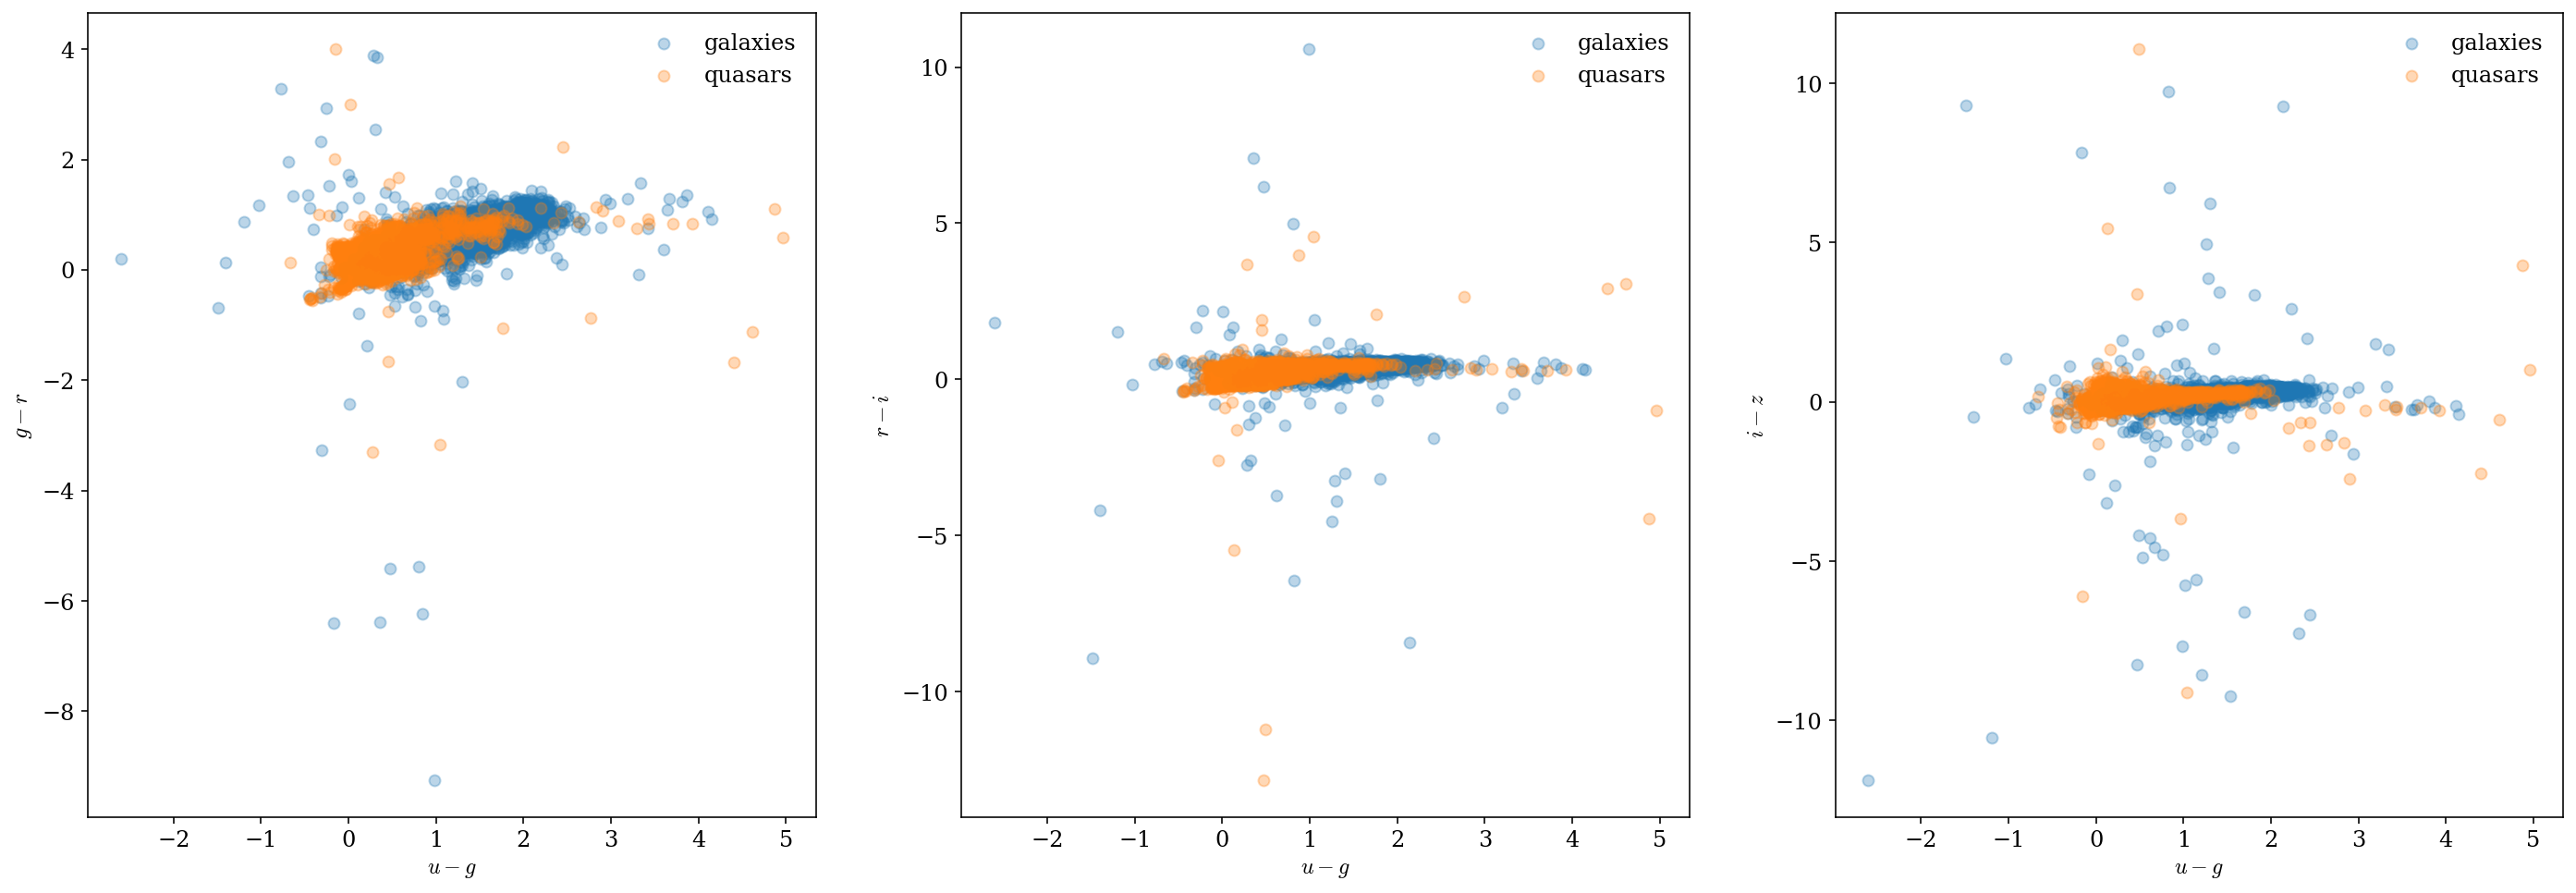

In [7]:
fig, axs = plt.subplots(1,3, figsize = (24,8))

axs[0].scatter(ug_train[labels_train == 0], gr_train[labels_train == 0], alpha=0.3, label='galaxies')
axs[0].scatter(ug_train[labels_train == 1], gr_train[labels_train == 1], alpha=0.3, label='quasars')
axs[0].set_xlabel(r'$u-g$') 
axs[0].set_ylabel(r'$g-r$')
axs[0].legend(frameon = False)

axs[1].scatter(ug_train[labels_train == 0], ri_train[labels_train == 0], alpha=0.3, label='galaxies')
axs[1].scatter(ug_train[labels_train == 1], ri_train[labels_train == 1], alpha=0.3, label='quasars')
axs[1].set_xlabel(r'$u-g$') 
axs[1].set_ylabel(r'$r-i$')
axs[1].legend(frameon = False)

axs[2].scatter(ug_train[labels_train == 0], iz_train[labels_train == 0], alpha=0.3, label='galaxies')
axs[2].scatter(ug_train[labels_train == 1], iz_train[labels_train == 1], alpha=0.3, label='quasars')
axs[2].set_xlabel(r'$u-g$') 
axs[2].set_ylabel(r'$i-z$')
axs[2].legend(frameon = False)

plt.show()

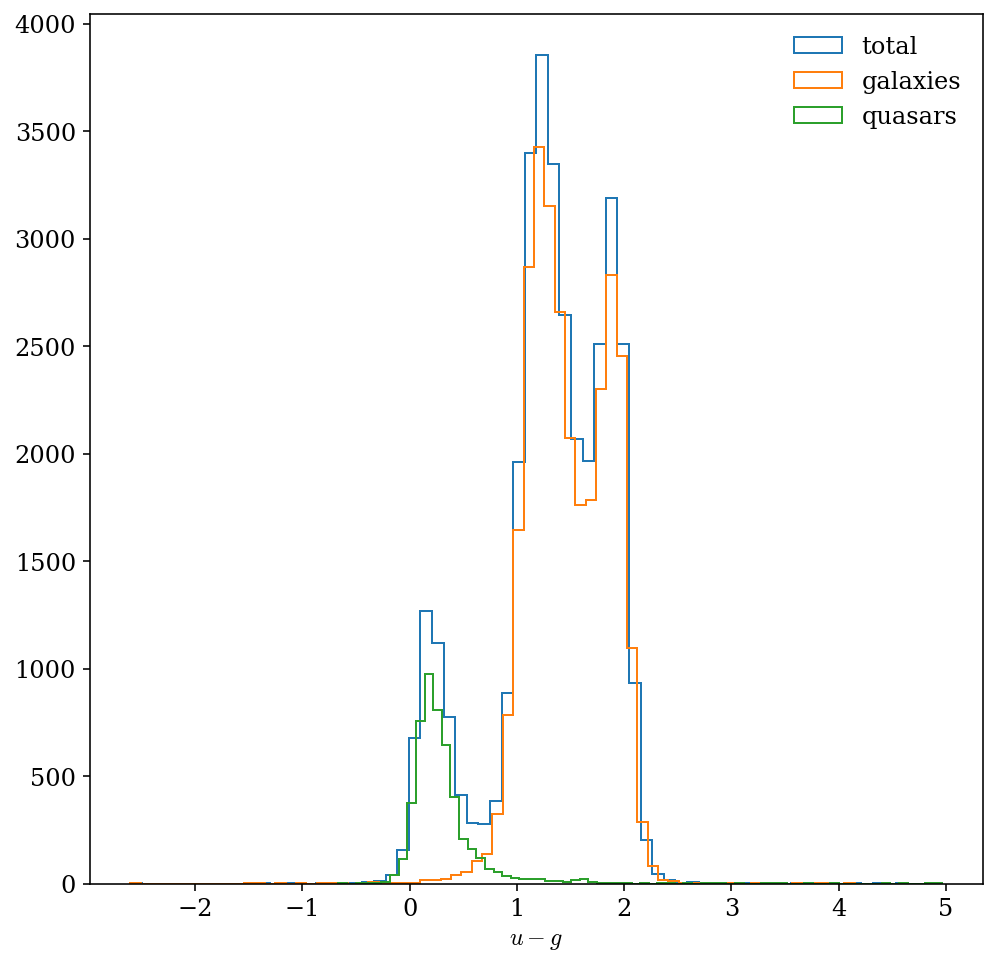

In [8]:
plt.hist(ug_train, bins = 70, histtype = 'step', label='total')
plt.hist(ug_train[labels_train == 0], bins = 70, histtype = 'step', label='galaxies')
plt.hist(ug_train[labels_train == 1], bins = 70, histtype = 'step', label='quasars')

plt.xlabel(r'$u-g$')
plt.legend(frameon = False)
plt.show()

## Classification

In [9]:
def return_accuracy(pred, test):
    true = len(pred[pred == test])
    return true / len(test)

In [10]:
accuracy = [] #best accuracy for each classifier
best_N = [] #number @ which the best accuracy is achieved 

### Gaussian naive bayes

In [11]:
classifiers, labels_pred, labels_proba = [], [], []
N = colors_train.shape[1] + 1
for n in range(1, N): #try with different colors
    X_train = colors_train[:,0:n]
    X_test = colors_test[:,0:n]

    clf = GaussianNB()
    clf.fit(X_train, labels_train)

    classifiers.append(clf)

    labels_pred.append(clf.predict(X_test))
    labels_proba.append(clf.predict_proba(X_test)[:,1])

In [12]:
# Compute the decision boundary
clf = classifiers[1] #2 colors
xlim = (min(X_train[:,0]), max(X_train[:,0]))
ylim = (min(X_train[:,1]), max(X_train[:,1]))

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 81),
                     np.linspace(ylim[0], ylim[1], 71))

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

In [13]:
# ROC curve
fpr_list, tpr_list, thresh_list = [], [], []

for proba in labels_proba:
    fpr, tpr, thresh = roc_curve(labels_test, proba) #false and true positive rate + treshold
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    thresh_list.append(thresh)

In [14]:
#contamination and completeness
completeness, contamination = completeness_contamination(labels_pred, labels_test)
print('completeness: ', completeness)
print('contamination: ', contamination)

completeness:  [0.93871866 0.93732591 0.93454039 0.93454039]
contamination:  [0.06691278 0.11135563 0.11125828 0.11671786]


In [15]:
#accuracy
accuracy_NB = []
for pred in labels_pred:
    acc = return_accuracy(pred, labels_test)
    accuracy_NB.append(acc)
accuracy.append(max(accuracy_NB))
best_N.append(range(1,len(labels_pred)+1)[np.argmax(accuracy_NB)])

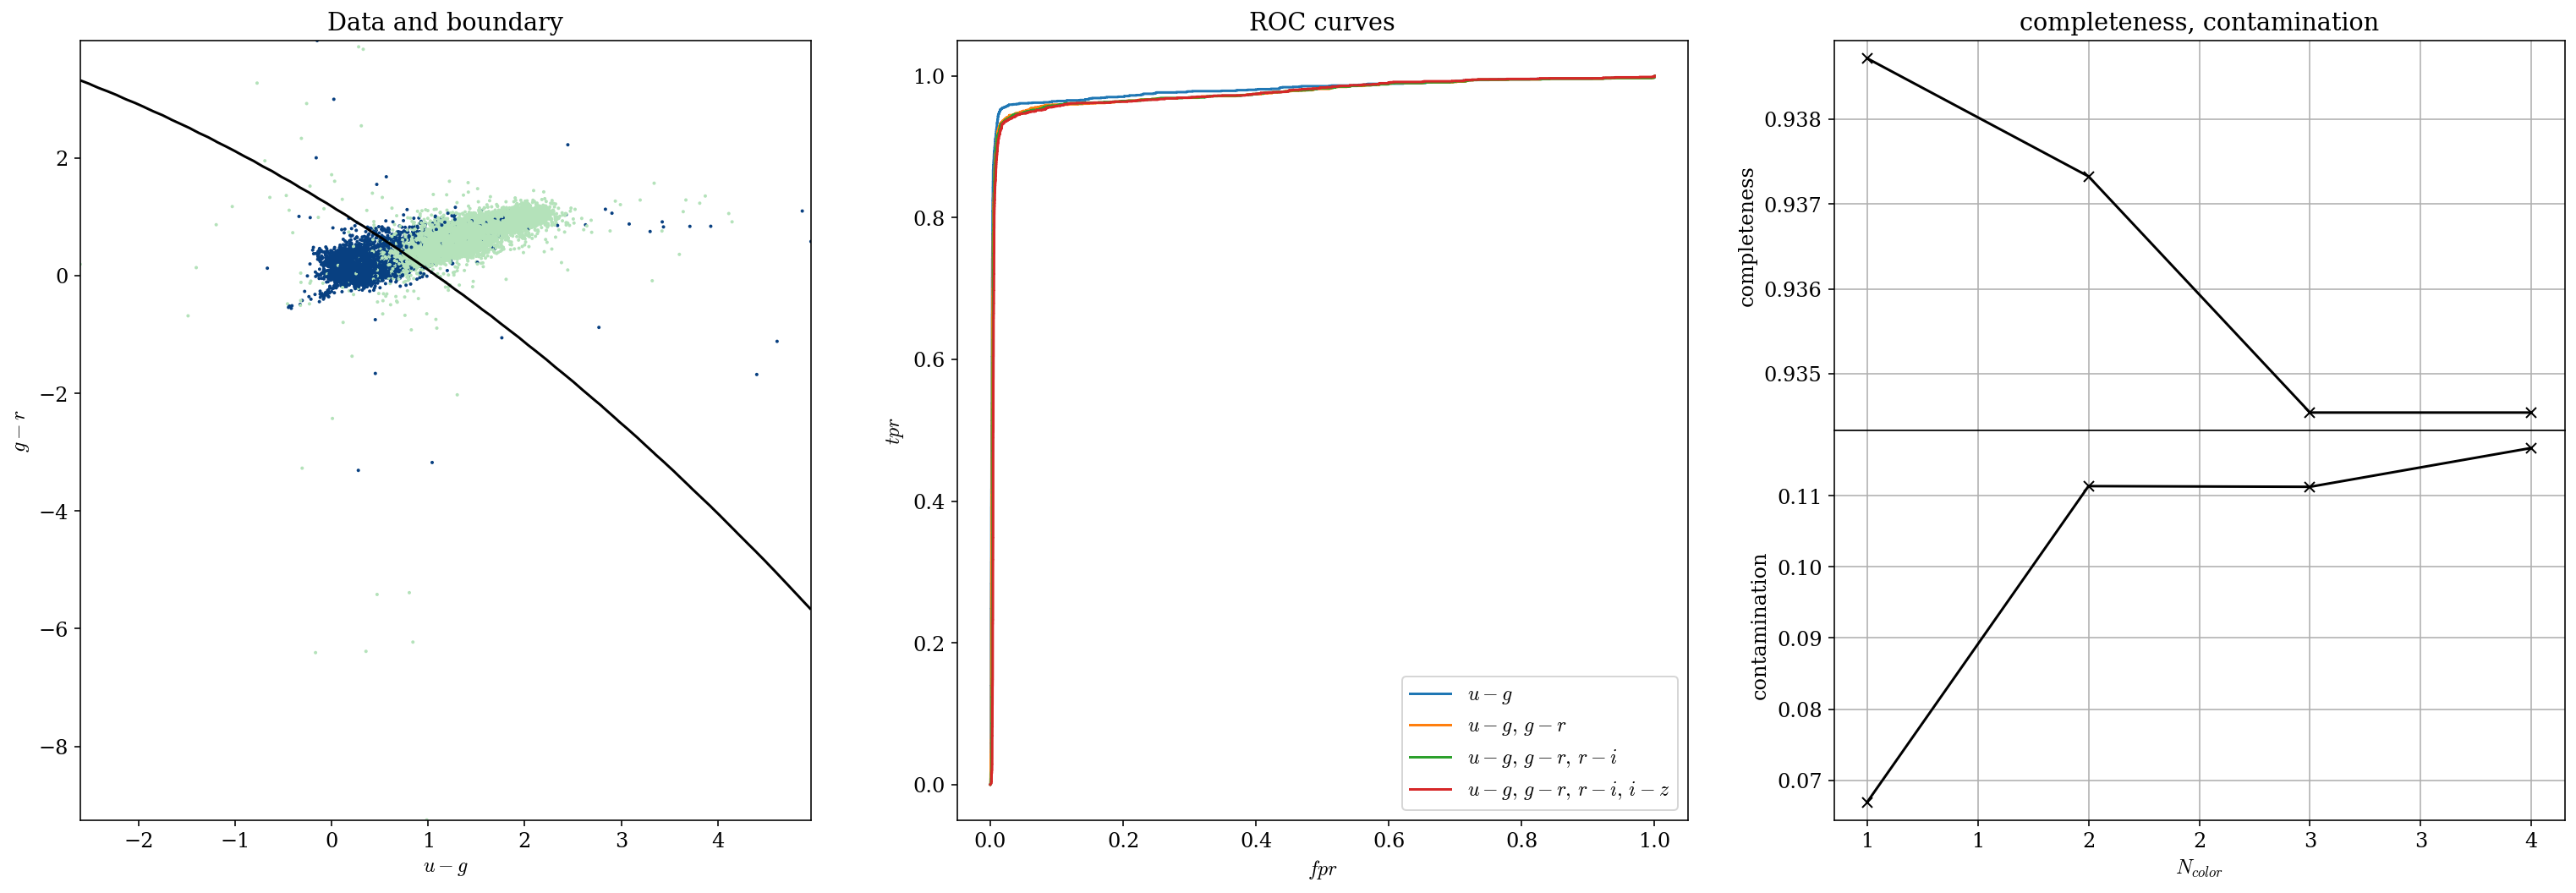

In [16]:
fig = plt.figure(figsize=(24, 8))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)
ax1 = plt.subplot(131) #data: u-g vs g-r
ax2 = plt.subplot(132) #roc curves
ax3 = plt.subplot(233) #completeness
ax4 = plt.subplot(236) #contamination
#------------------------------------------------------------
im = ax1.scatter(X_train[:, 0], X_train[:, 1], c=labels_train,
                s=4, lw=0, cmap=plt.cm.GnBu, zorder=2)
im.set_clim(-0.5, 1)

ax1.contour(xx, yy, Z, [0.5], colors='k')

ax1.set_xlim(xlim)
ax1.set_ylim(ylim)

ax1.set_xlabel(r'$u-g$')
ax1.set_ylabel(r'$g-r$')
ax1.set_title('Data and boundary')
#------------------------------------------------------------
labels_plot = [r'$u-g$', r'$u-g, \,g-r$', r'$u-g, \,g-r, \,r-i$', r'$u-g, \,g-r, \,r-i, \,i-z$']
for fpr, tpr, label in zip(fpr_list, tpr_list, labels_plot):
    ax2.plot(fpr, tpr, label = label)
    ax2.legend()
    
ax2.set_xlabel(r'$fpr$')
ax2.set_ylabel(r'$tpr$')
ax2.set_title('ROC curves')
#------------------------------------------------------------
ax3.plot(range(1,N), completeness, 'x-k')
ax3.set_ylabel('completeness')
ax3.xaxis.set_major_formatter(plt.NullFormatter())
ax3.set_title('completeness, contamination')
ax3.grid(True)
#------------------------------------------------------------
ax4.plot(range(1,N), contamination, 'x-k')
ax4.set_xlabel(r'$N_{color}$')
ax4.set_ylabel('contamination')
ax4.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax4.grid(True)
#------------------------------------------------------------
plt.show()

**$u-g$ is the most important feature** (as expected from the corner plot, it's the only color with a relevant variability)

### GMM Bayes

classifiers, labels_pred, labels_proba = [], [], []
N = colors_train.shape[1] + 1

comp_range = np.arange(1,5) #CV

for n in range(1, N): #try with different colors
    X_train = colors_train[:,0:n]
    X_test = colors_test[:,0:n]
    
    grid = GridSearchCV(GMMBayes(), {'n_components': comp_range}, cv=5)
    grid.fit(X_train, labels_train)
    n_opt = grid.best_params_['n_components']

    clf = GMMBayes(n_opt)
    clf.fit(X_train, labels_train)

    classifiers.append(clf)

    labels_pred.append(clf.predict(X_test))
    labels_proba.append(clf.predict_proba(X_test)[:,1])

In [17]:
classifiers, labels_pred, labels_proba = [], [], []
N = colors_train.shape[1] + 1

for n in range(1, N): #try with different colors
    X_train = colors_train[:,0:n]
    X_test = colors_test[:,0:n]
    
    clf = GMMBayes(5)
    clf.fit(X_train, labels_train)

    classifiers.append(clf)

    labels_pred.append(clf.predict(X_test))
    labels_proba.append(clf.predict_proba(X_test)[:,1])

In [18]:
# Compute the decision boundary
clf = classifiers[1] #2 colors
xlim = (min(X_train[:,0]), max(X_train[:,0]))
ylim = (min(X_train[:,1]), max(X_train[:,1]))

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 81),
                     np.linspace(ylim[0], ylim[1], 71))

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

In [19]:
# ROC curve
fpr_list, tpr_list, thresh_list = [], [], []

for proba in labels_proba:
    fpr, tpr, thresh = roc_curve(labels_test, proba) #false and true positive rate + treshold
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    thresh_list.append(thresh)

In [20]:
#contamination and completeness
completeness, contamination = completeness_contamination(labels_pred, labels_test)
print('completeness: ', completeness)
print('contamination: ', contamination)

completeness:  [0.94011142 0.93175487 0.94289694 0.93500464]
contamination:  [0.0736505  0.05285512 0.09813499 0.06499536]


In [21]:
#accuracy
accuracy_GMM = []
for pred in labels_pred:
    acc = return_accuracy(pred, labels_test)
    accuracy_GMM.append(acc)
accuracy.append(max(accuracy_GMM))
best_N.append(range(1,len(labels_pred)+1)[np.argmax(accuracy_GMM)])

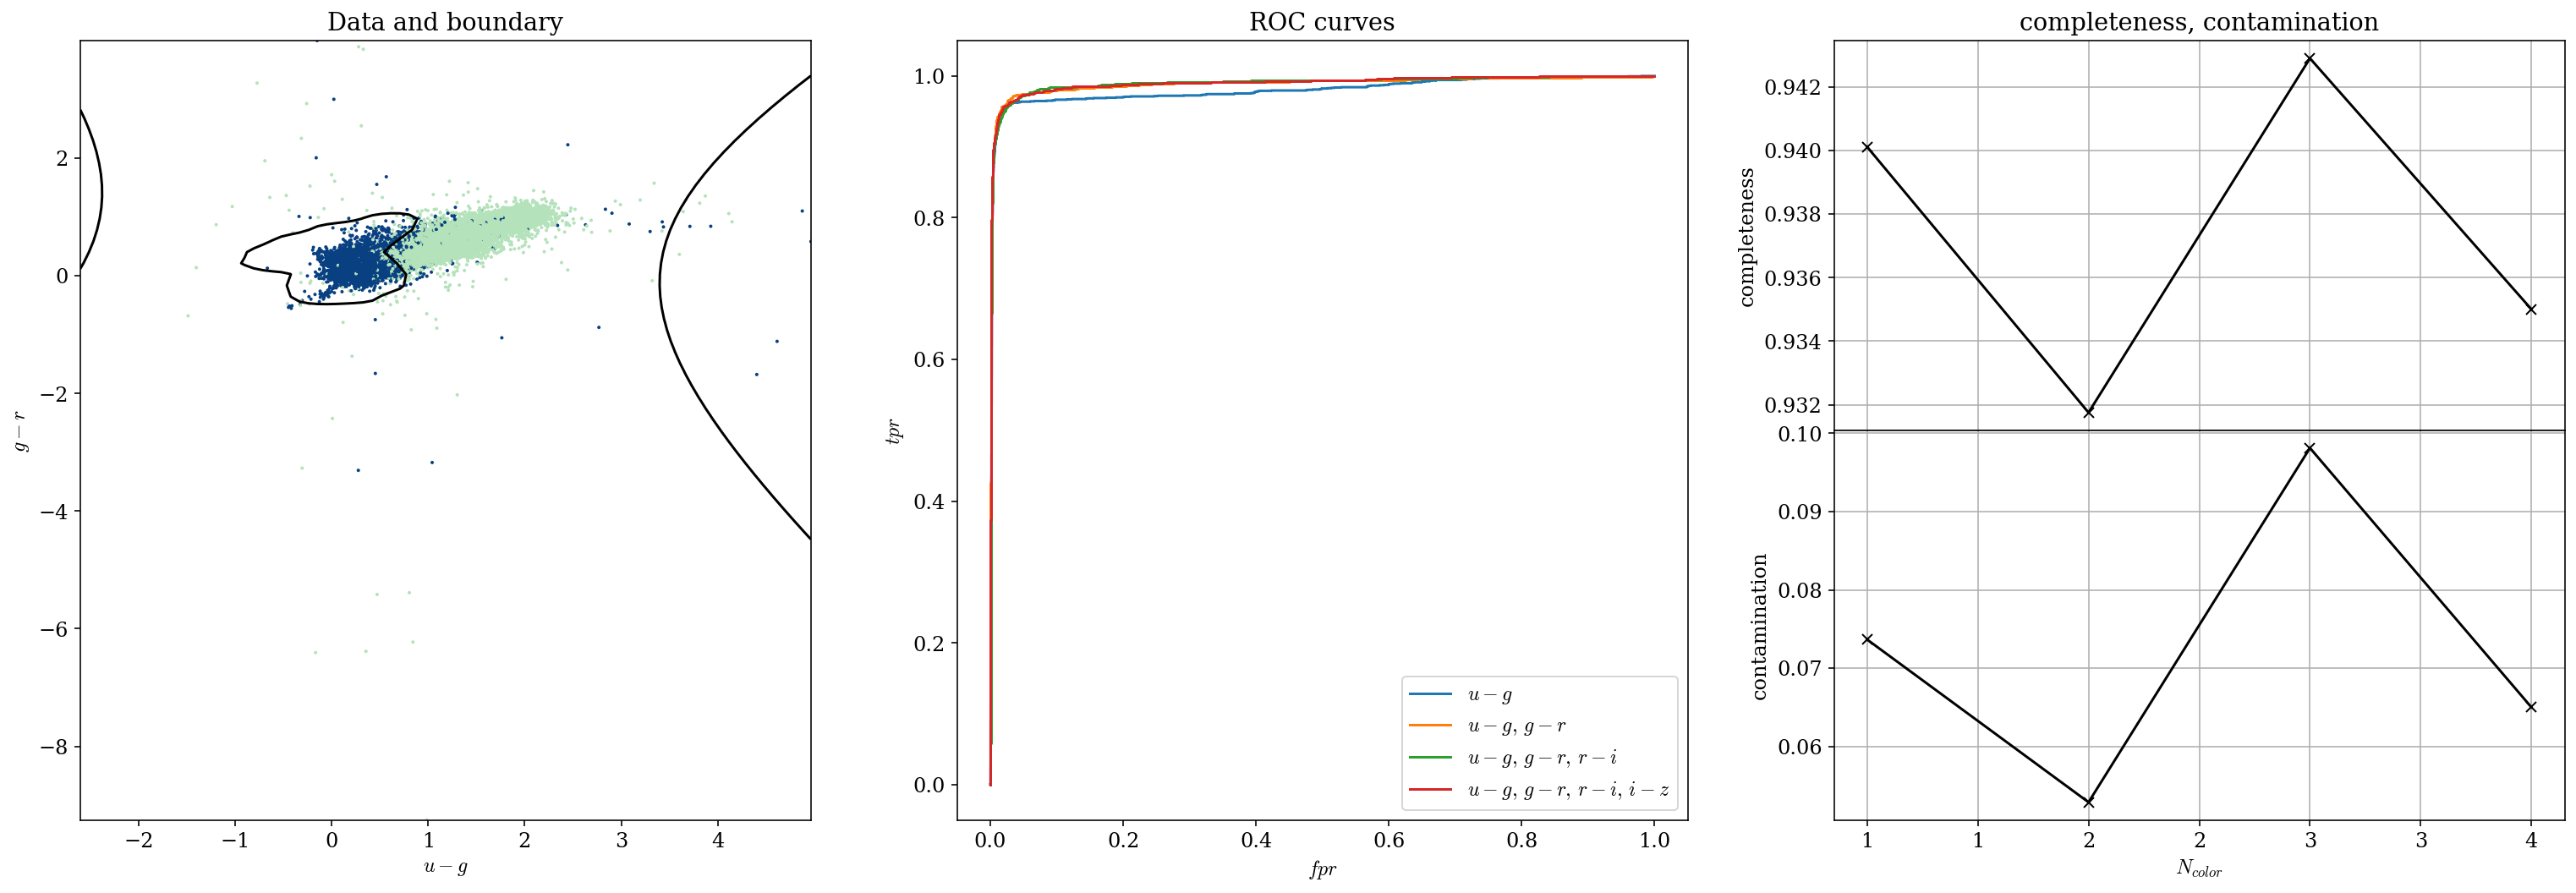

In [22]:
fig = plt.figure(figsize=(24, 8))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)
ax1 = plt.subplot(131) #data: u-g vs g-r
ax2 = plt.subplot(132) #roc curves
ax3 = plt.subplot(233) #completeness
ax4 = plt.subplot(236) #contamination
#------------------------------------------------------------
im = ax1.scatter(X_train[:, 0], X_train[:, 1], c=labels_train,
                s=4, lw=0, cmap=plt.cm.GnBu, zorder=2)
im.set_clim(-0.5, 1)

ax1.contour(xx, yy, Z, [0.5], colors='k')

ax1.set_xlim(xlim)
ax1.set_ylim(ylim)

ax1.set_xlabel(r'$u-g$')
ax1.set_ylabel(r'$g-r$')
ax1.set_title('Data and boundary')
#------------------------------------------------------------
labels_plot = [r'$u-g$', r'$u-g, \,g-r$', r'$u-g, \,g-r, \,r-i$', r'$u-g, \,g-r, \,r-i, \,i-z$']
for fpr, tpr, label in zip(fpr_list, tpr_list, labels_plot):
    ax2.plot(fpr, tpr, label = label)
    ax2.legend()
    
ax2.set_xlabel(r'$fpr$')
ax2.set_ylabel(r'$tpr$')
ax2.set_title('ROC curves')
#------------------------------------------------------------
ax3.plot(range(1,N), completeness, 'x-k')
ax3.set_ylabel('completeness')
ax3.xaxis.set_major_formatter(plt.NullFormatter())
ax3.set_title('completeness, contamination')
ax3.grid(True)
#------------------------------------------------------------
ax4.plot(range(1,N), contamination, 'x-k')
ax4.set_xlabel(r'$N_{color}$')
ax4.set_ylabel('contamination')
ax4.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax4.grid(True)
#------------------------------------------------------------
plt.show()

### K-Nearest Neighbor

In [23]:
def CV(X_train, labels_train, kvals):
    grid = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': kvals}, cv = 5)
    grid.fit(X_train, labels_train)
    best_k = grid.best_params_['n_neighbors']
    return best_k

In [24]:
classifiers, labels_pred, labels_proba = [], [], []
N = colors_train.shape[1] + 1
kvals = np.arange(1,15)
k_used = []
for n in range(1, N): #try with different colors
    X_train = colors_train[:,0:n]
    X_test = colors_test[:,0:n]
    #-- CV
    best_k = CV(X_train, labels_train, kvals)
    print(best_k)
    k_used.append(best_k)
    #–-
    clf = KNeighborsClassifier(n_neighbors = best_k)
    clf.fit(X_train, labels_train)

    classifiers.append(clf)

    labels_pred.append(clf.predict(X_test))
    labels_proba.append(clf.predict_proba(X_test)[:,1])

9
12
14
13


In [25]:
# Compute the decision boundary
clf = classifiers[1] #2 colors
xlim = (min(X_train[:,0]), max(X_train[:,0]))
ylim = (min(X_train[:,1]), max(X_train[:,1]))

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 81),
                     np.linspace(ylim[0], ylim[1], 71))

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

In [26]:
# ROC curve
fpr_list, tpr_list, thresh_list = [], [], []

for proba in labels_proba:
    fpr, tpr, thresh = roc_curve(labels_test, proba)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    thresh_list.append(thresh)

In [27]:
#contamination and completeness
completeness, contamination = completeness_contamination(labels_pred, labels_test)
print('completeness: ', completeness)
print('contamination: ', contamination)

completeness:  [0.93407614 0.93500464 0.94336119 0.94707521]
contamination:  [0.06331471 0.05312647 0.0433145  0.04225352]


In [28]:
#accuracy
accuracy_k = []
for pred in labels_pred:
    acc = return_accuracy(pred, labels_test)
    accuracy_k.append(acc)
accuracy.append(max(accuracy_k))
best_N.append(range(1,len(labels_pred) + 1)[np.argmax(accuracy_k)])

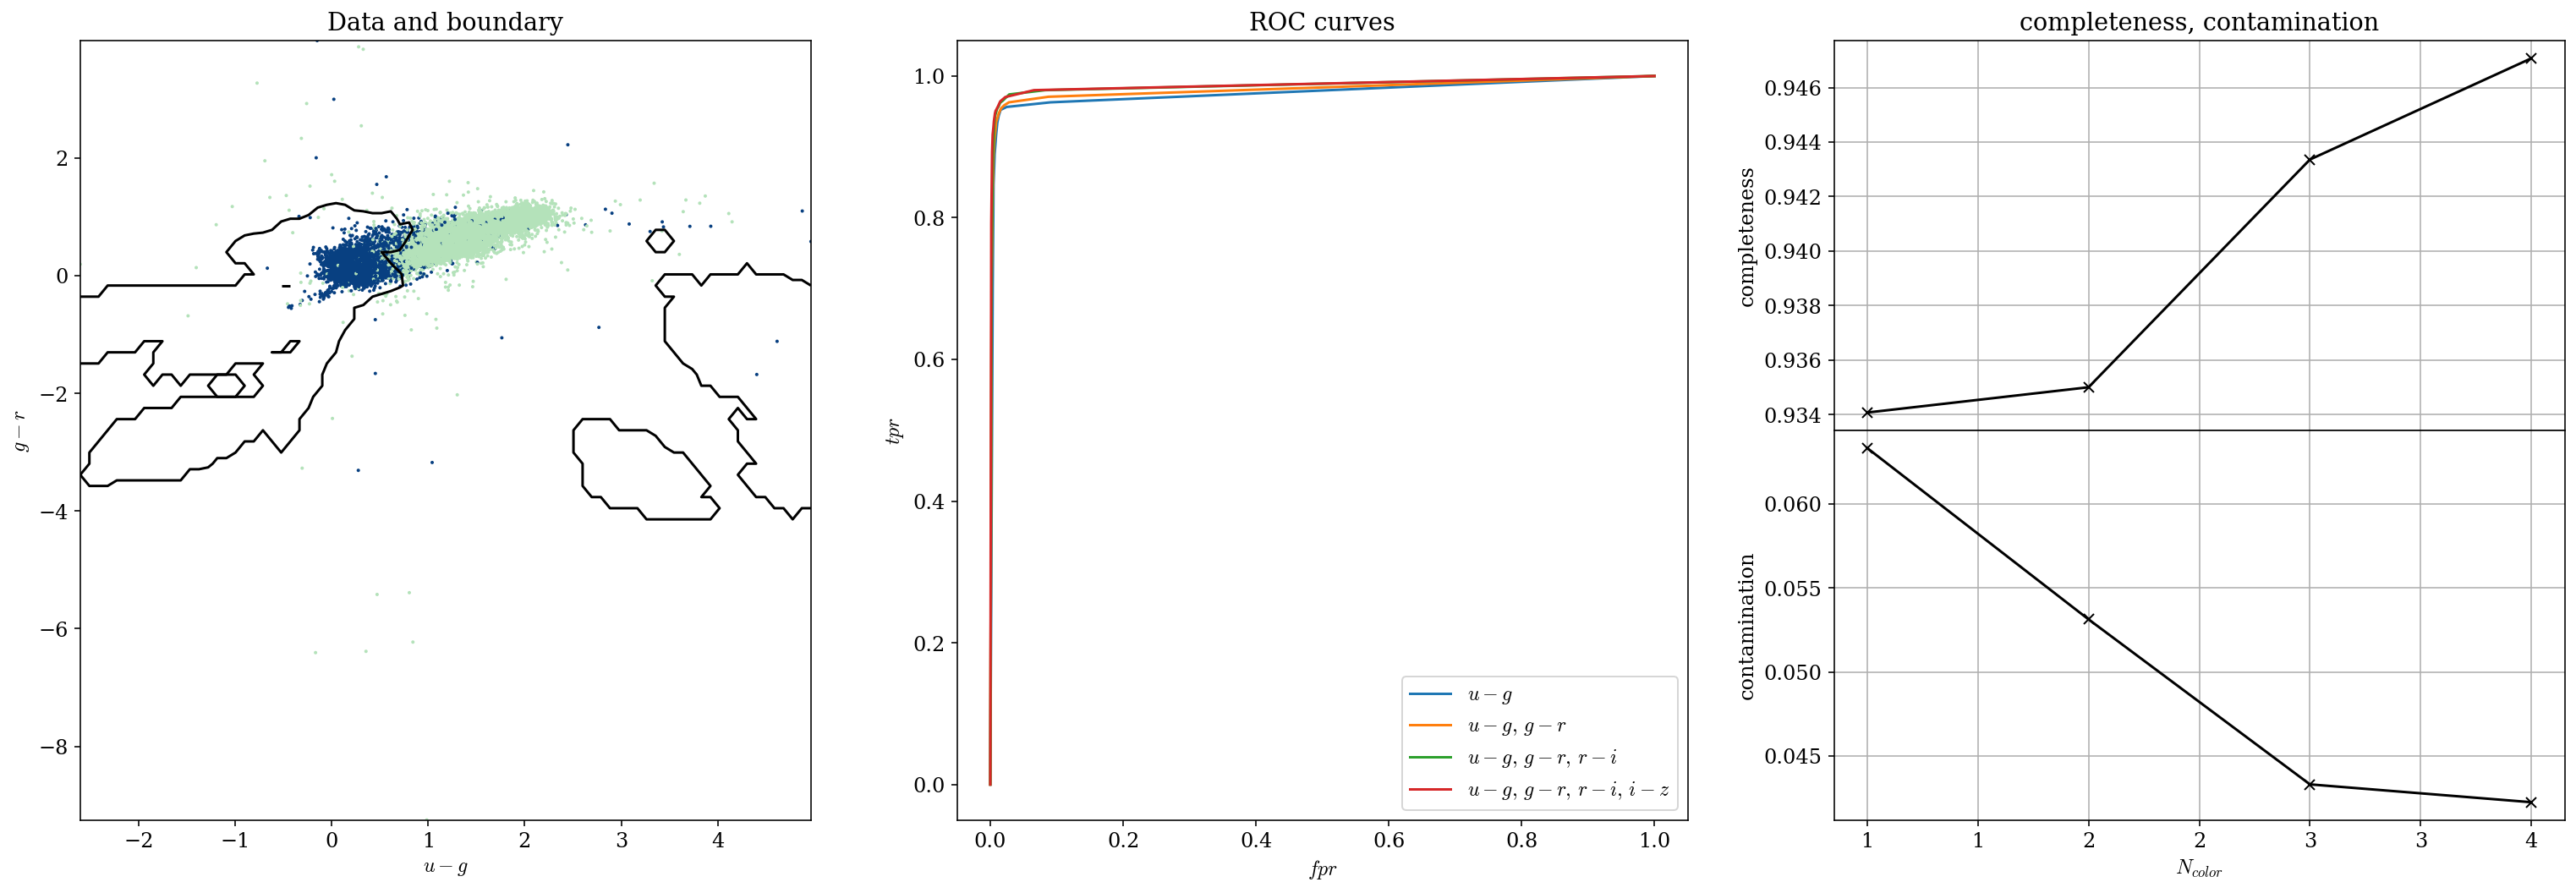

In [29]:
fig = plt.figure(figsize=(24, 8))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)
ax1 = plt.subplot(131) #data: u-g vs g-r
ax2 = plt.subplot(132) #roc curves
ax3 = plt.subplot(233) #completeness
ax4 = plt.subplot(236) #contamination
#------------------------------------------------------------
im = ax1.scatter(X_train[:, 0], X_train[:, 1], c=labels_train,
                s=4, lw=0, cmap=plt.cm.GnBu, zorder=2)
im.set_clim(-0.5, 1)

ax1.contour(xx, yy, Z, [0.5], colors='k')

ax1.set_xlim(xlim)
ax1.set_ylim(ylim)

ax1.set_xlabel(r'$u-g$')
ax1.set_ylabel(r'$g-r$')
ax1.set_title('Data and boundary')
#------------------------------------------------------------
labels_plot = [r'$u-g$', r'$u-g, \,g-r$', r'$u-g, \,g-r, \,r-i$', r'$u-g, \,g-r, \,r-i, \,i-z$']
for fpr, tpr, label in zip(fpr_list, tpr_list, labels_plot):
    ax2.plot(fpr, tpr, label = label)
    ax2.legend()
    
ax2.set_xlabel(r'$fpr$')
ax2.set_ylabel(r'$tpr$')
ax2.set_title('ROC curves')
#------------------------------------------------------------
ax3.plot(range(1,N), completeness, 'x-k')
ax3.set_ylabel('completeness')
ax3.xaxis.set_major_formatter(plt.NullFormatter())
ax3.set_title('completeness, contamination')
ax3.grid(True)
#------------------------------------------------------------
ax4.plot(range(1,N), contamination, 'x-k')
ax4.set_xlabel(r'$N_{color}$')
ax4.set_ylabel('contamination')
ax4.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax4.grid(True)
#------------------------------------------------------------
plt.show()

In [30]:
print('The cross validated numbers of neighbors are: ')
for i, k in enumerate(k_used):
    i+=1
    if i == 1:
        print('%i for %i color' % (k,i))
    else:
        print('%i for %i colors' % (k,i))

The cross validated numbers of neighbors are: 
9 for 1 color
12 for 2 colors
14 for 3 colors
13 for 4 colors


In [31]:
methods = ['Gaussian naive bayes', 'GMM Bayes', 'K-Nearest Neighbor']
for name, acc, n in zip(methods, accuracy, best_N):
    print(name + ': accuracy = %.4f for Ncolors = %i' % (acc, n))

Gaussian naive bayes: accuracy = 0.9815 for Ncolors = 1
GMM Bayes: accuracy = 0.9827 for Ncolors = 2
K-Nearest Neighbor: accuracy = 0.9864 for Ncolors = 4


### -----

## TensorFlow  
use all the colors

In [32]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
import os
from time import time

In [33]:
#clean the log directory
#!rm -rf ./logs/
#!rm -rf ./logsL19_trained/

#trained model
#!rm -rf ./L19_trained.h5

In [34]:
#hyperparameters
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete(np.arange(1, 2*len(colors_train[0]) + 1).tolist()))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
HP_ACT_FUNCTION = hp.HParam('activation', hp.Discrete(['relu', 'tanh']))
METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/L19_hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_OPTIMIZER, HP_ACT_FUNCTION],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

2022-07-04 17:17:21.520342: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [35]:
#functions
#---
def rescale_colors(colors):
    rescaled_colors = np.zeros_like(colors)
    for i in range(len(colors[0])):
        lims = min(colors[:,i]), max(colors[:,i])
        rescaled_colors[:,i] = 1 - 2 * (colors[:, i] - lims[0]) / (lims[1] - lims[0])
    return rescaled_colors
#---
#CV for the hyperparams
def train_test_model(colors_train, labels_train, colors_test, labels_test, hparams):

    train_in  = rescale_colors(colors_train)
    train_out = labels_train
    test_in  = rescale_colors(colors_test)
    test_out = labels_test

    # Kernel initializer
    my_init = tf.keras.initializers.glorot_uniform(seed=1)
    # Define neural network architecture
    model = tf.keras.Sequential([
        # Input layer, do not change
        tf.keras.layers.InputLayer(input_shape=np.shape(train_in[0])),
        # Inner layers, can add/change
        tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=hparams[HP_ACT_FUNCTION], kernel_initializer=my_init),
        # Output layer, do not change
        tf.keras.layers.Dense(1, activation='sigmoid',kernel_initializer=my_init)])

    model.compile(
        optimizer = hparams[HP_OPTIMIZER],
        loss='binary_crossentropy',
        metrics=['accuracy'])

    model.fit(colors_train, labels_train, epochs=5) 
    _, accuracy = model.evaluate(colors_test, labels_test)
    return accuracy
#---
def run(run_dir, colors_train, labels_train, colors_test, labels_test, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(colors_train, labels_train, colors_test, labels_test, hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
    return accuracy
#---
def trainnetwork(colors_train, labels_train, colors_test, labels_test, hparams, filename='L19_trained.h5'):

    if not os.path.isfile(filename):

        train_in  = rescale_colors(colors_train)
        train_out = labels_train
        test_in  = rescale_colors(colors_test)
        test_out = labels_test

        # Kernel initializer
        my_init = tf.keras.initializers.glorot_uniform(seed=1)
        # Define neural network architecture
        model = tf.keras.Sequential([
            # Input layer, do not change
            tf.keras.layers.InputLayer(input_shape=np.shape(train_in[0])),
            # Inner layers, can add/change
            tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=hparams[HP_ACT_FUNCTION], kernel_initializer=my_init),
            # Output layer, do not change
            tf.keras.layers.Dense(1, activation='sigmoid',kernel_initializer=my_init)])
    
        if hparams[HP_OPTIMIZER] == 'adam':
            opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
        elif hparams[HP_OPTIMIZER] == 'sgd':
            opt = tf.keras.optimizers.SGD(learning_rate=1e-2)
        else:
            print('ERROR')
            raise ValueError
        model.compile(
            # Optimization algorithm, specify learning rate
            optimizer = opt,
            # Loss function for a binary classifier
            loss='binary_crossentropy',
            # Diagnostic quantities
            metrics=['accuracy'])

        # Decrease the learning rate exponentially after the first 10 epochs
        def scheduler(epoch, lr):
            if epoch < 10:
                return lr
            else:
                return lr * tf.math.exp(-0.01)

        # Actual Training
        history = model.fit(
            # Training inputs
            train_in,
            # Training outputs
            train_out,
            # Evaluate test set at each epoch
            validation_data=(test_in, test_out),
            # Batch size, default is 32
            #batch_size=32,
            # Number of epochs
            epochs=100,
            # Store the model with the best validation accuracy
            callbacks = [
                # Drecrease learning rate
                tf.keras.callbacks.LearningRateScheduler(scheduler),
                # Store the model with the best validation accuracy
                tf.keras.callbacks.ModelCheckpoint(
                    filepath=filename,
                    save_weights_only=False,
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True),
                # Save logfiles for tensorboard
                tf.keras.callbacks.TensorBoard(log_dir="logs"+filename.split('.h5')[0], histogram_freq=1)],
            # Shuffle data at each epoch
            shuffle=True)

    model = loadnetwork(filename)
    return model
#---
def loadnetwork(filename,verbose=False):
    '''
    Load a trained neural network
    '''

    model = tf.keras.models.load_model(filename)
    if verbose:
        model.summary()

    return model
#---
def testnetwork(model, colors_test, labels_test):
    '''
    Test network 
    '''
    test_in  = rescale_colors(colors_test)
    test_out = labels_test
    model.evaluate(test_in,  test_out, verbose=2)
#---
def predictnetwork(model, colors_test):
    '''
    Use a network to predict the class.
    '''
    # Return the class (0 or 1) that is preferred
    predictions = np.squeeze((model.predict(rescale_colors(colors_test)) > 0.5).astype("int32"))
    return predictions

In [36]:
#trained file:
filename='L19_trained.h5'

In [37]:
hparams = {
            HP_NUM_UNITS: 0,
            HP_OPTIMIZER: 0,
            HP_ACT_FUNCTION: 0
        }
#VALIDATION
if not os.path.isfile(filename):
    tmp = time()
    accuracy_best = 0
    session_num = 0

    for num_units in HP_NUM_UNITS.domain.values:
        for optimizer in HP_OPTIMIZER.domain.values:
            for activation in HP_ACT_FUNCTION.domain.values:
                hparams = {
                    HP_NUM_UNITS: num_units,
                    HP_OPTIMIZER: optimizer,
                    HP_ACT_FUNCTION: activation
                }
                run_name = "run-%d" % session_num
                print('--- Starting trial: %s' % run_name)
                print({h.name: hparams[h] for h in hparams})
                accuracy_try = run('logs/hparam_tuning/' + run_name, colors_train, labels_train, colors_test, labels_test, hparams)
                session_num += 1
        
                if accuracy_try > accuracy_best:
                    accuracy_best = accuracy_try
                    best_num_units = num_units
                    best_optimizer = optimizer
                    best_activation = activation
            
    hparams = {
            HP_NUM_UNITS: best_num_units,
            HP_OPTIMIZER: best_optimizer,
            HP_ACT_FUNCTION: best_activation
        }
    print(hparams)
    print(accuracy_best)
    
    tmp = time() - tmp
    print('---- \nThe cross validation took %.2f s' % tmp)

In [38]:
model = trainnetwork(colors_train, labels_train, colors_test, labels_test, hparams, filename=filename)

In [39]:
testnetwork(model, colors_test, labels_test)

469/469 - 1s - loss: 0.2920 - accuracy: 0.8596 - 847ms/epoch - 2ms/step


In [40]:
labels_pred = predictnetwork(model, colors_test)
accuracy = return_accuracy(labels_pred, labels_test)
print('accuracy of the nn: ', accuracy)

accuracy of the nn:  0.8596


In [41]:
%tensorboard --logdir logs/hparam_tuning